In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, mannwhitneyu, skew, fisher_exact
from statsmodels.stats.proportion import proportions_ztest

from sklearn.datasets import make_classification

# числові значення

In [100]:
def evaluate_groups(
    df, 
    target_col='target', 
    value_col='gross_summ', 
    n_iter=None, 
    bootstrap_size=None, 
    plot=True, 
    alternative="two-sided"
):
    """
    Оцінює різницю між двома групами (target vs control) за допомогою бутстрепу 
    та статистичних тестів (t-тест і критерій Манна-Вітні).
    
    Параметри
    ---------
    df : pandas.DataFrame
        Вхідний датафрейм з даними, що містить стовпці для групування та метрики.
    
    target_col : str, за замовчуванням 'target'
        Назва стовпця, що визначає групу. 
        Очікується, що там є два значення: 
        - 1 для target (експериментальної групи),
        - 0 для control (контрольної групи).
    
    value_col : str, за замовчуванням 'gross_summ'
        Назва стовпця з метрикою/значеннями, які потрібно порівняти між групами.
    
    n_iter : int, за замовчуванням 1% розміру датафрейму
        Кількість ітерацій бутстрепу (перегенерацій випадкових вибірок).
        Якщо None → використовується 1/100 від розміру всього датафрейму.

    bootstrap_size : int, за замовчуванням 1% розміру датафрейму
        Розмір випадкової вибірки для бутстрепу. 
        Якщо None → використовується 1/100 від розміру всього датафрейму.

    plot : bool, за замовчуванням True
        Якщо True → будується гістограма розподілу різниць середніх, 
        з позначенням середнього значення та довірчого інтервалу.
    
    alternative : {'two-sided', 'greater', 'less'}, за замовчуванням 'two-sided'
        Тип статистичного тесту:
        - 'two-sided' → перевіряється, чи відрізняються середні (будь-який напрямок).
        - 'greater' → перевіряється, чи середнє у групі target > control.
        - 'less' → перевіряється, чи середнє у групі target < control.
    
    Повертає
    --------
    pandas.DataFrame
        Таблиця з результатами оцінки, яка містить:
        - Metric/Field : назва метрики (value_col),
        - Mean Difference : середня різниця між групами (target - control),
        - CI Lower : нижня межа 95% бутстрепного довірчого інтервалу,
        - CI Upper : верхня межа 95% бутстрепного довірчого інтервалу,
        - T-test p-value (...) : p-value для t-тесту з відповідним `alternative`,
        - Mann-Whitney p-value (...) : p-value для тесту Манна-Вітні з відповідним `alternative`.
        - Cohen's d : стандартізований ефект (сила ефекту)
            - ≈0 → дуже слабкий ефект
            - 0.2 → малий ефект
            - 0.5 → середній ефект
            - 0.8 → великий ефект
        - target_mean / control_mean : середнє значення для кожної групи
        - target_median / control_median : медіана для кожної групи
        - target_std / control_std : стандартне відхилення
        - target_var / control_var : дисперсія
        - target_min / control_min : мінімум
        - target_max / control_max : максимум
        - target_skew / control_skew : асиметрія розподілу
            - ≈0 → симетричний розподіл
            - >0 → права «хвістова» асиметрія (значення з великими викидами)
            - <0 → ліва «хвістова» асиметрія (значення з маленькими викидами)
        - target_kurtosis / control_kurtosis : куртозис
            - ≈0 → розподіл схожий на нормальний
            - >0 → гострий пік та важкі хвости (часто екстремальні значення)
            - <0 → плоский розподіл, легкі хвости

    графік (якщо plot=True)
        - Гістограма розподілу різниць середніх з позначенням середнього та довірчого інтервалу.
        Якщо нуль поза межами довірчого інтервалу → можна вважати, що різниця статистично значуща.

    Зауваження
    ----------
    - Бутстреп дає емпіричний розподіл різниць середніх, що дозволяє оцінити довірчий інтервал.
    - t-тест вважає, що дані приблизно нормально розподілені, хоча може бути стійким до відхилень.
    - Критерій Манна-Вітні не робить припущень про нормальність і підходить для порівняння медіан.
    - Усі p-value за замовчуванням двосторонні, якщо не вказати інше через `alternative`.
    
    Приклади
    --------
    >>> evaluate_groups(df, value_col="revenue", alternative="two-sided")
    >>> evaluate_groups(df, value_col="deposit", n_iter=500, alternative="greater", plot=False)
    """

    tr_values = df[df[target_col] == 1][value_col].values
    co_values = df[df[target_col] == 0][value_col].values

    bootstrap_size = bootstrap_size if bootstrap_size else int(len(df) / 100)
    n_iter = n_iter if n_iter else int(len(df) / 100)

    # --- Bootstrap ---
    tr_means = []
    co_means = []
    diffs = []

    for _ in range(n_iter):
        tr_sample = np.random.choice(tr_values, size=bootstrap_size, replace=True)
        co_sample = np.random.choice(co_values, size=bootstrap_size, replace=True)

        tr_mean = tr_sample.mean()
        co_mean = co_sample.mean()

        tr_means.append(tr_mean)
        co_means.append(co_mean)
        diffs.append(tr_mean - co_mean)

    mean_diff = np.mean(diffs)

    # --- Confidence intervals ---
    tr_ci_lower, tr_ci_upper = np.percentile(tr_means, [2.5, 97.5])
    co_ci_lower, co_ci_upper = np.percentile(co_means, [2.5, 97.5])

    if alternative == "less":
        ci_lower = -np.inf
        ci_upper = np.percentile(diffs, 95)
    elif alternative == "greater":
        ci_lower = np.percentile(diffs, 5)
        ci_upper = np.inf
    else:  # "two-sided"
        ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])

    # --- Statistical tests ---
    t_stat, t_p = ttest_ind(tr_values, co_values, alternative=alternative)
    mw_stat, mw_p = mannwhitneyu(tr_values, co_values, alternative=alternative)

    cohen_d = (
        (np.mean(tr_values) - np.mean(co_values)) /
        np.sqrt((np.var(tr_values) + np.var(co_values)) / 2)
    )

    # --- Distribution stats ---
    stats = {
        'target_skew': skew(tr_values),
        'control_skew': skew(co_values),
        'target_kurtosis': pd.Series(tr_values).kurtosis(),
        'control_kurtosis': pd.Series(co_values).kurtosis(),
    }

    result = {
        'Metric/Field': value_col,
        'Mean Difference': round(mean_diff, 3),
        'CI Lower': round(ci_lower, 3),
        'CI Upper': round(ci_upper, 3),
        f'T-test p-value ({alternative})': round(t_p, 3),
        f'Mann-Whitney p-value ({alternative})': round(mw_p, 3),
        "Cohen's d": round(cohen_d, 3),
        **{k: round(v, 3) for k, v in stats.items()}
    }

    # --- Common x-axis limits for group means ---
    x_min = min(np.min(tr_means), np.min(co_means))
    x_max = max(np.max(tr_means), np.max(co_means))

    pad = 0.05 * (x_max - x_min)
    x_min -= pad
    x_max += pad

    # --- Plot ---
    if plot:
        fig, axes = plt.subplots(3, 1, figsize=(9, 8))

        # === Target mean ===
        axes[1].hist(tr_means, bins=40, density=True,
                     color='orange', edgecolor='black')
        axes[1].axvline(np.mean(tr_means),
                        color='red', linestyle='--', linewidth=2)
        axes[1].axvspan(tr_ci_lower, tr_ci_upper,
                        color='orange', alpha=0.2)
        axes[1].set_title(
            f'Target mean = {np.mean(tr_means):.2f} '
            f'± {(tr_ci_upper - tr_ci_lower)/2:.2f}'
        )
        axes[1].set_xlim(x_min, x_max)

        # === Control mean ===
        axes[0].hist(co_means, bins=40, density=True,
                     color='steelblue', edgecolor='black')
        axes[0].axvline(np.mean(co_means),
                        color='red', linestyle='--', linewidth=2)
        axes[0].axvspan(co_ci_lower, co_ci_upper,
                        color='steelblue', alpha=0.2)
        axes[0].set_title(
            f'Control mean = {np.mean(co_means):.2f} '
            f'± {(co_ci_upper - co_ci_lower)/2:.2f}'
        )
        axes[0].set_xlim(x_min, x_max)

        # === Difference of means ===
        axes[2].hist(diffs, bins=40, density=True,
                     color='gray', edgecolor='black')
        axes[2].axvline(mean_diff,
                        color='red', linestyle='--', linewidth=2,
                        label=f'Mean diff: {mean_diff:.2f}')
        axes[2].axvspan(
            ci_lower if np.isfinite(ci_lower) else min(diffs),
            ci_upper if np.isfinite(ci_upper) else max(diffs),
            color='gray', alpha=0.25, label='95% CI'
        )
        axes[2].axvline(0, color='black', linewidth=1)
        axes[2].set_title(
            f'Difference of means: {mean_diff:.2f} '
            f'CI [{ci_lower:.2f}, {ci_upper:.2f}]'
            )

        for ax in axes:
            ax.grid(alpha=0.2)

        plt.tight_layout()
        plt.show()

    return result

In [101]:
# Класичні класифікаційні дані
X, y = make_classification(
    n_samples=10000,
    n_features=4,
    n_informative=4,
    n_redundant=0,
    n_clusters_per_class=4,
    random_state=42
)

# Робимо gross_summ з легкою різницею між класами
gross_summ = X[:, 0]*50 + np.random.normal(0, 15, size=10000)  # більше шуму
gross_summ += np.where(y==1, 25, 0)  # слабкий ефект для класу 1

df_fake = pd.DataFrame({
    'user_id': np.random.randint(1, 200, size=10000),
    'gross_summ': np.abs(gross_summ),
    'target': y
})

df_fake.head()

,user_id,gross_summ,target
0,182,23.047608,0
1,103,31.760615,0
2,17,10.465950,1
3,96,46.519887,0
4,47,32.202652,1


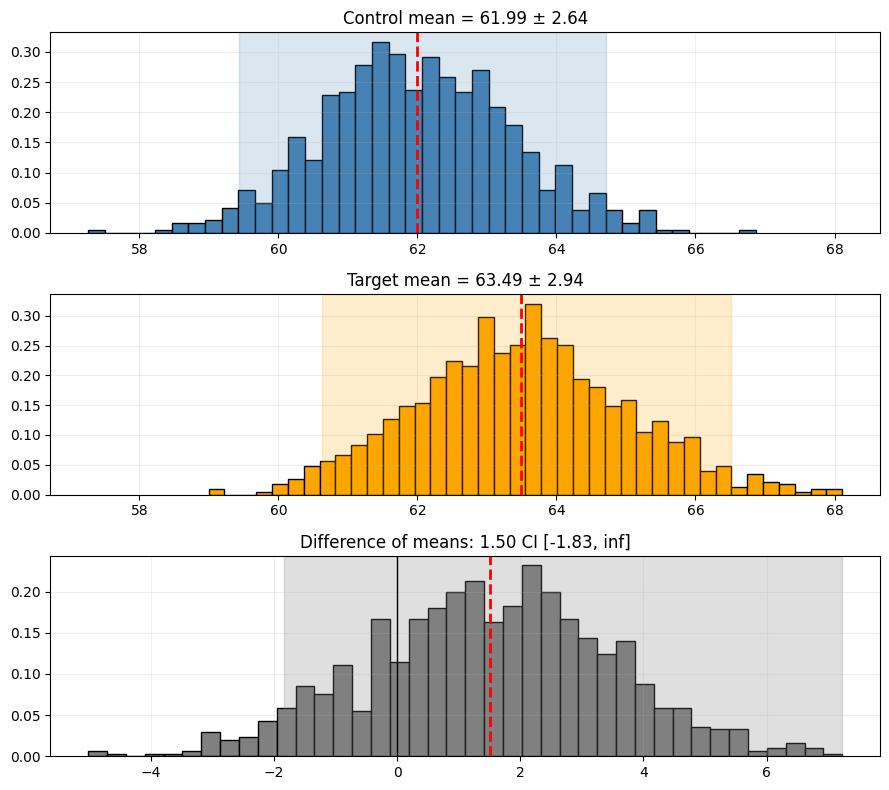

{'Metric/Field': 'gross_summ',
 'Mean Difference': 1.504,
 'CI Lower': -1.832,
 'CI Upper': inf,
 'T-test p-value (greater)': 0.041,
 'Mann-Whitney p-value (greater)': 0.217,
 "Cohen's d": 0.035,
 'target_skew': 0.857,
 'control_skew': 0.787,
 'target_kurtosis': 0.581,
 'control_kurtosis': 0.24}

In [102]:
res = evaluate_groups(df_fake, alternative="greater", plot=True, value_col='gross_summ', n_iter=1000, bootstrap_size=1000)
res

# бінарні значення

In [103]:
def evaluate_binary_groups(
    df, 
    target_col='target', 
    value_col='conversion', 
    n_iter=None, 
    bootstrap_size=None, 
    plot=True, 
    alternative="two-sided"
):
    """
    Оцінка різниці між двома бінарними групами (0/1) з бутстрепом та статистичними тестами.
    Повертає результати та графік з групами і розподілом різниці пропорцій.

    Параметри
    ---------
    df : pandas.DataFrame
        Вхідний датафрейм з даними, що містить стовпці для групування та метрики.
    target_col : str, за замовчуванням 'target'
        Назва стовпця, що визначає групу. 
        Очікується, що там є два значення: 
        - 1 для target (експериментальної групи),
        - 0 для control (контрольної групи).
    value_col : str, за замовчуванням 'conversion'
        Назва стовпця з бінарною метрикою/значеннями (0/1), які потрібно порівняти між групами.
    n_iter : int, за замовчуванням 1% розміру датафрейму
        Кількість ітерацій бутстрепу (перегенерацій випадкових вибірок).
        Якщо None → використовується 1/100 від розміру всього датафрейму.
    bootstrap_size : int, за замовчуванням 1% розміру датафрейму
        Розмір випадкової вибірки для бутстрепу. 
        Якщо None → використовується 1/100 від розміру всього датафрейму.
    plot : bool, за замовчуванням True
        Якщо True → будується гістограма розподілу різниць пропорцій, з позначенням середнього значення та довірчого інтервалу.
    alternative : {'two-sided', 'greater', 'less'}, за замовчуванням 'two-sided'
        Тип статистичного тесту:
        - 'two-sided' → перевіряється, чи відрізняються пропорції (будь-який напрямок).
        - 'greater' → перевіряється, чи пропорція у групі target > control.
        - 'less' → перевіряється, чи пропорція у групі target < control.
    """
    
    tr_values = df[df[target_col] == 1][value_col].values
    co_values = df[df[target_col] == 0][value_col].values

    bootstrap_size = bootstrap_size if bootstrap_size else int(len(df) / 100)
    n_iter = n_iter if n_iter else int(len(df) / 100)

    # --- Bootstrap для різниці пропорцій ---
    tr_means = []
    co_means = []
    diffs = []

    for _ in range(n_iter):
        tr_sample = np.random.choice(tr_values, size=bootstrap_size, replace=True)
        co_sample = np.random.choice(co_values, size=bootstrap_size, replace=True)

        tr_mean = tr_sample.mean()
        co_mean = co_sample.mean()

        tr_means.append(tr_mean)
        co_means.append(co_mean)
        diffs.append(tr_mean - co_mean)

    diffs = np.array(diffs)
    mean_diff = diffs.mean()
    
    # --- Confidence intervals ---
    tr_ci_lower, tr_ci_upper = np.percentile(tr_means, [2.5, 97.5])
    co_ci_lower, co_ci_upper = np.percentile(co_means, [2.5, 97.5])

    if alternative == "less":
        ci_lower = -np.inf
        ci_upper = np.percentile(diffs, 95)
    elif alternative == "greater":
        ci_lower = np.percentile(diffs, 5)
        ci_upper = np.inf
    else:  # "two-sided"
        ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])

    # --- Z-test для пропорцій ---
    count = np.array([tr_values.sum(), co_values.sum()])
    nobs = np.array([len(tr_values), len(co_values)])
    z_stat, z_p = proportions_ztest(count, nobs, alternative=alternative)
    
    # --- Fisher exact test ---
    table = np.array([
        [tr_values.sum(), len(tr_values)-tr_values.sum()],
        [co_values.sum(), len(co_values)-co_values.sum()]
    ])
    _, p_fisher = fisher_exact(table, alternative=alternative)

    # --- Результати ---
    result = {
        'Metric/Field': value_col,
        'Mean Difference (prop)': round(mean_diff, 3),
        'CI Lower': round(ci_lower, 3),
        'CI Upper': round(ci_upper, 3),
        f'Z-test p-value ({alternative})': round(z_p, 3),
        f'Fisher p-value ({alternative})': round(p_fisher, 3),
        'target_prop': round(tr_values.mean(), 3),
        'control_prop': round(co_values.mean(), 3),
        'target_count': len(tr_values),
        'control_count': len(co_values)
    }

    # --- Common x-axis limits for group means ---
    x_min = min(np.min(tr_means), np.min(co_means))
    x_max = max(np.max(tr_means), np.max(co_means))

    pad = 0.05 * (x_max - x_min)
    x_min -= pad
    x_max += pad

    # --- Plot ---
    if plot:
        fig, axes = plt.subplots(3, 1, figsize=(9, 8))

        # === Target mean ===
        axes[1].hist(tr_means, bins=40, density=True,
                     color='orange', edgecolor='black')
        axes[1].axvline(np.mean(tr_means),
                        color='red', linestyle='--', linewidth=2)
        axes[1].axvspan(tr_ci_lower, tr_ci_upper,
                        color='orange', alpha=0.2)
        axes[1].set_title(
            f'Target mean = {np.mean(tr_means):.2f} '
            f'± {(tr_ci_upper - tr_ci_lower)/2:.2f}'
        )
        axes[1].set_xlim(x_min, x_max)

        # === Control mean ===
        axes[0].hist(co_means, bins=40, density=True,
                     color='steelblue', edgecolor='black')
        axes[0].axvline(np.mean(co_means),
                        color='red', linestyle='--', linewidth=2)
        axes[0].axvspan(co_ci_lower, co_ci_upper,
                        color='steelblue', alpha=0.2)
        axes[0].set_title(
            f'Control mean = {np.mean(co_means):.2f} '
            f'± {(co_ci_upper - co_ci_lower)/2:.2f}'
        )
        axes[0].set_xlim(x_min, x_max)

        # === Difference of means ===
        axes[2].hist(diffs, bins=40, density=True,
                     color='gray', edgecolor='black')
        axes[2].axvline(mean_diff,
                        color='red', linestyle='--', linewidth=2,
                        label=f'Mean diff: {mean_diff:.2f}')
        axes[2].axvspan(
            ci_lower if np.isfinite(ci_lower) else min(diffs),
            ci_upper if np.isfinite(ci_upper) else max(diffs),
            color='gray', alpha=0.25, label='95% CI'
        )
        axes[2].axvline(0, color='black', linewidth=1)
        axes[2].set_title(
            f'Difference of means: {mean_diff:.2f} '
            f'CI [{ci_lower:.2f}, {ci_upper:.2f}]'
            )

        for ax in axes:
            ax.grid(alpha=0.2)

        plt.tight_layout()
        plt.show()

    return result

In [104]:
# --- Генеруємо класифікаційні дані ---
X, y = make_classification(
    n_samples=10000,
    n_features=4,
    n_informative=4,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=42
)

# --- Створюємо бінарну метрику conversion ---
# Бінарний результат 0/1 з трохи більшою ймовірністю для класу 1
conversion = np.zeros(10000, dtype=int)
conversion[y == 0] = np.random.binomial(1, 0.3, size=(y==0).sum())
conversion[y == 1] = np.random.binomial(1, 0.32, size=(y==1).sum())

# --- Формуємо DataFrame ---
df_fake = pd.DataFrame({
    'user_id': np.random.randint(1, 200, size=10000),
    'conversion': conversion,
    'target': y
})

df_fake.head()

,user_id,conversion,target
0,31,0,0
1,51,0,1
2,55,0,0
3,73,0,0
4,10,0,0


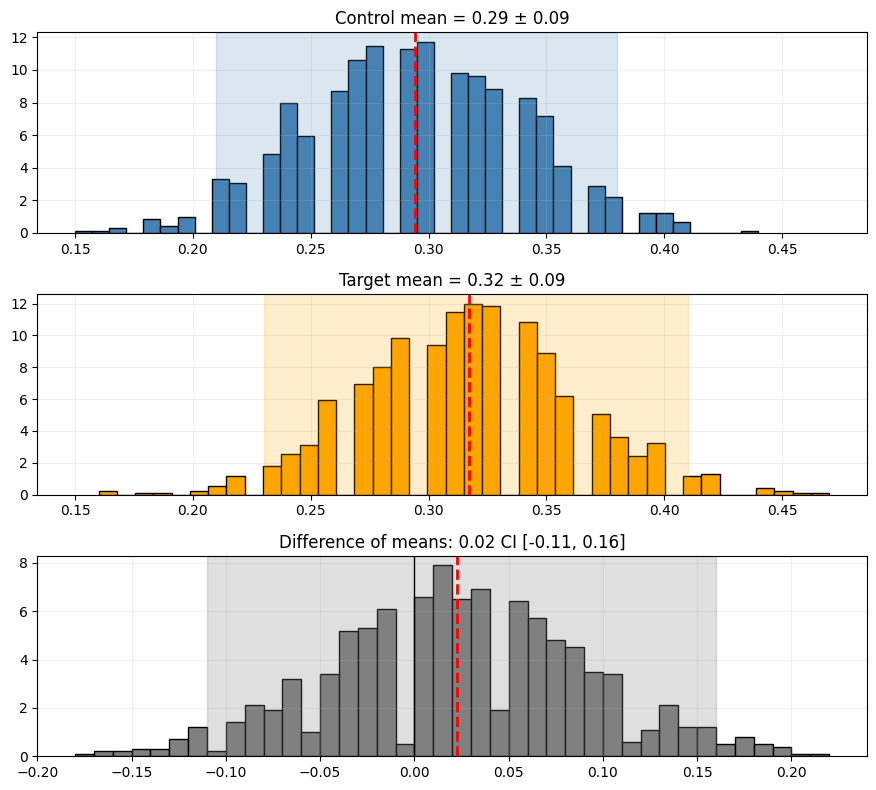

{'Metric/Field': 'conversion',
 'Mean Difference (prop)': 0.023,
 'CI Lower': -0.11,
 'CI Upper': 0.16,
 'Z-test p-value (two-sided)': 0.012,
 'Fisher p-value (two-sided)': 0.012,
 'target_prop': 0.318,
 'control_prop': 0.295,
 'target_count': 5001,
 'control_count': 4999}

In [105]:
evaluate_binary_groups(df_fake, plot=True, value_col='conversion', n_iter=1000)